

# Cycle Generative Adversarial Network (CycleGAN)

    ↪ 두 개의 다른 도메인 데이터 집합을 두고, Discriminator loss + cycle loss(x==>y'==>x``와 x의 차이) + identity loss(x==>y`와 y의 차이)로 도메인 간 차이를 이용하여 학습하는 생성모델.

#### ▢ CGAN의 단점 보완
    (1) 데이터셋의 cost
        ↪ CGAN의 경우 학습을 위해 조건과 타겟 데이터의 쌍이 필요한데, 이 데이터셋을 준비하기 위한 작업량이 너무 큼.
        CycleGAN은 두 개의 다른 특징을 가지는 도메인 데이터 집합만으로 조건에 대한 학습이 가능하기 때문에 데이터 전처리 작업량을 크게 줄일 수 있음.

#### ▢ CycleGAN Loss
    ✔ Generator
        ↪ G : x로부터 y`를 생성하는 Generator
           F : y로부터 x` 생성하는 Generator

        1. Adversarial loss : target domain에 있을 법한 이미지를 생성하도록
            (1) loss_G_xy = criterion_G.forward_G(d_g_x, real_label) : y`를 y로 인식하면 성공
            (2) loss_F_yx = criterion_G.forward_G(d_f_y, real_label) : x`를 x로 인식하면 성공
                                ↪ BCEWithLogitsLoss 사용


        2. Cycle-consistent loss : 입력과 매칭되는 image-to-image translation 결과 이미지를 찾을 수 있도록
            x ≒ F(G(x)) = x''
            y ≒ G(F(x)) = y''

            (3) loss_cyc = criterion_cyc(X, Y, rec_x, rec_y)
                    ↪ (x ⇒ y` ⇒ x``)와 x의 차이 + (y ⇒ x` ⇒ y``) 와 y의 차이
                        ↪ L1Loss 사용

        3. Identity loss
            y ≒ G(x) = y'
            x ≒ F(y) = x'

            (4) loss_idt = criterion_idt(X, Y, f_y, g_x)
                    ↪ (x ⇒ y`)와 y의 차이 + (y ⇒ x`)와 x의 차이
                        ↪ L1Loss 사용

        G_loss = (1) + (2) + (3) + (4)

    ✔ Discriminator
        (1) loss_D_xy = criterion_D.forward_D(D_y(Y), real_label, D_y(g_x.detach()), fake_label)
            ↪ real을 real로, fake를 fake로 인식하면 성공
        (2) loss_D_yx = criterion_D.forward_D(D_x(X), real_label, D_x(f_y.detach()), fake_label)

        # average the loss
        ↪ loss_D = (loss_D_xy + loss_D_yx)/2


#### ▢ CycleGAN의 구현

    ✔ 네트워크 아키텍처
        - residual block을 활용하는 아키텍처 및 instance normalization 사용

        - 이미지 내 패치 단위로 진위 여부를 판별하는 discriminator 사용

    ✔ 학습 방법
        - Least-squares loss : 기존의 cross-entropy 기반의 loss 대신 MSEloss 사용
            실제 이미지 분포와 더욱 가까운 이미지를 생성할 수 있고, 학습이 안정화됨

        - Replay buffer : generator가 만든 이전 50개의 이미지를 저장해두고, 이를 이용해 discriminator가 업데이트. 모델의 oscillation이 개선됨.



#### Colab Link
    https://colab.research.google.com/drive/18tJ37PYiApHwVX_NOlAm8WzeHxSN4dEe?usp=sharing


#### Reference
    https://github.com/YoojLee/paper_review/tree/main/code/cycle_gan
    https://github.com/ndb796/PyTorch-Image-to-Image-Translation/tree/main

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

import os
import glob
import random
random.seed(52)
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from typing import List, Dict

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from typing import Optional

from torch.utils.data import Dataset, DataLoader

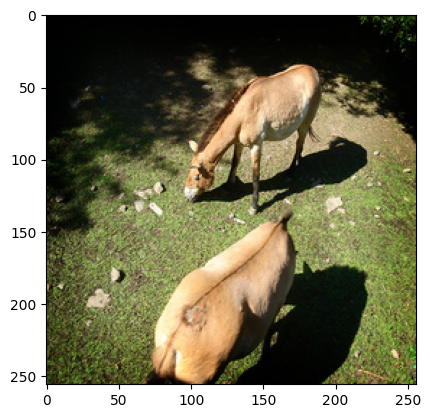

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Python/Tutorial/5_DeepLearning/generatives/GAN/data/horse2zebra'

image_files = os.listdir(data_dir+'/trainA')
temp_img_list = glob.glob(data_dir+'/trainA' + '/*')
temp_img = cv2.imread(temp_img_list[0])
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
plt.imshow(temp_img)

In [ ]:
class UnalignedDataset(Dataset):
    def __init__(self, data_root_A: str, data_root_B: str, is_train:bool=True, transforms=ToTensorV2()):
        super(UnalignedDataset, self).__init__()
        self.data_root_A = data_root_A
        self.data_root_B = data_root_B
        self.is_train = is_train
        self.transforms = transforms

        paths_A = sorted(self._load_image_path(self.data_root_A))
        paths_B = sorted(self._load_image_path(self.data_root_B))

        # A와 B의 길이가 다른 경우를 위해 handling
        self.image_paths_A, self.image_paths_B = self._adjust_dataset_length(paths_A, paths_B)


    def __len__(self):
        return len(self.image_paths_A)

    def __getitem__(self, index:int)->Dict:
        A = cv2.cvtColor(cv2.imread(self.image_paths_A[index]), cv2.COLOR_BGR2RGB)
        B = cv2.cvtColor(cv2.imread(self.image_paths_B[index]), cv2.COLOR_BGR2RGB)

        if self.transforms:
            A = self.transforms(image=A)['image'] # for albumentations
            B = self.transforms(image=B)['image']

        return {'A': A, 'B': B}

    def _load_image_path(self, data_dir:str)->List[str]:
        image_path  = glob.glob(data_dir+"/*") # 상위 경로까지 포함해서 리턴

        return image_path

    def _adjust_dataset_length(self, paths_A:str, paths_B:str):
        min_len = min(len(paths_A), len(paths_B))
        return paths_A[:min_len], paths_B[:min_len]


['/content/drive/MyDrive/Colab Notebooks/인공지능 공부/LAIDD/나동빈/GAN/data/horse2zebra/trainA/n02381460_1001.jpg', '/content/drive/MyDrive/Colab Notebooks/인공지능 공부/LAIDD/나동빈/GAN/data/horse2zebra/trainA/n02381460_1002.jpg', '/content/drive/MyDrive/Colab Notebooks/인공지능 공부/LAIDD/나동빈/GAN/data/horse2zebra/trainA/n02381460_1003.jpg']
['/content/drive/MyDrive/Colab Notebooks/인공지능 공부/LAIDD/나동빈/GAN/data/horse2zebra/trainB/n02391049_10007.jpg', '/content/drive/MyDrive/Colab Notebooks/인공지능 공부/LAIDD/나동빈/GAN/data/horse2zebra/trainB/n02391049_10027.jpg', '/content/drive/MyDrive/Colab Notebooks/인공지능 공부/LAIDD/나동빈/GAN/data/horse2zebra/trainB/n02391049_1004.jpg']
1067
AxesImage(size=(256, 256))


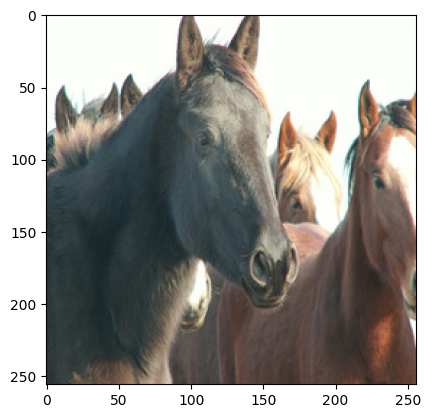

In [ ]:
train_set = UnalignedDataset(data_dir+'/trainA', data_dir+'/trainB', True)
print(train_set.image_paths_A[:3])
print(train_set.image_paths_B[:3])

print(len(train_set))

print(plt.imshow(np.transpose(train_set[0]['A'], (1, 2, 0))))

In [ ]:
# augmentation

class BaseAugmentation:
    def __init__(self, mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5]):
        self.transform = A.Compose([
                A.Normalize(mean=mean, std=std, always_apply=True),
                ToTensorV2()
        ])

def denormalize_image(image, mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5]):

    mean = 255.0*np.array(mean).reshape(-1,1,1)
    std = 255.0*np.array(std).reshape(-1,1,1)

    if len(image.shape) == 4 and image.shape[0]==1:
        image = image.squeeze()

    denorm_image = np.clip(image*std+mean, 0, 255)

    return denorm_image

In [ ]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

args = argparse.ArgumentParser()
args.trainA = data_dir+'/trainA'
args.trainB = data_dir+'/trainB'

args.testA = data_dir+'/testA'
args.testB = data_dir+'/testB'

args.batch_size = 1
args.lr = 0.0002
args.epochs = 20
args.beta1 = 0.5

args.lambda_idt = 0.5
args.lambda_cyc = 10.0

transforms = BaseAugmentation()

cpu


In [ ]:
train_set = UnalignedDataset(args.trainA, args.trainB, True, transforms=transforms.transform)
test_set = UnalignedDataset(args.testA, args.testB, False, transforms=transforms.transform)

train_loader = DataLoader(train_set, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size = args.batch_size, shuffle=False)

In [ ]:
# criterions

from torch import nn

class AdversarialLoss(nn.Module):
    def __init__(self):
        """
        두 개의 bce loss가 필요함.
        one for D(G(x)) vs real label (Generator)
        one for D(y) vs real label and D(G(x)) vs fake label (Discriminator)
        """
        super(AdversarialLoss, self).__init__()
        self.loss = nn.BCEWithLogitsLoss()

    # generator
    def forward_G(self, d_g_x, real):
        """
        - Args
            d_g_x: D(G(x)), a predicted probability of G(x) to be real
            real: true value (real label)
        """
        return self.loss(d_g_x, real)

    # discriminator
    def forward_D(self, d_y ,real, d_g_x, fake):
        """
        - Args
            d_y: D(y) a predicted probability that y is real
            real: true value (real label)
            d_g_x: D(G(x)), a predicted probability that y is true
            fake: true value (fake label)
        """
        d_real_loss = self.loss(d_y, real)
        d_fake_loss = self.loss(d_g_x, fake) # G(x) to be detached in order to prevent a gradient.

        d_loss = (d_real_loss + d_fake_loss)/2

        return d_loss

# x ==> y` ==> x``와 x를 비교하는 것 : cycle loss
class CycleConsistencyLoss(nn.Module):
    def __init__(self):
        super(CycleConsistencyLoss, self).__init__()
        self.loss_forward = nn.L1Loss()
        self.loss_backward = nn.L1Loss()

    def forward(self, x, y, f_g_x, g_f_y):
        """
        x, y -> true
        f_g_x, g_f_y -> pred
        """
        loss_cyc = self.loss_forward(f_g_x, x) + self.loss_backward(g_f_y, y) # pred, real의 순서 잘 지켜줄 것

        return loss_cyc

# x ==> y`를 y와 비교하는 것 : identity loss
class IdentityLoss(nn.Module):
    def __init__(self):
        super(IdentityLoss, self).__init__()
        self.loss_x = nn.L1Loss()
        self.loss_y = nn.L1Loss()

    def forward(self, x, y, f_y, g_x):
        loss_idt = self.loss_x(f_y, x) + self.loss_y(g_x, y)

        return loss_idt

In [ ]:
# scheduler

from torch.optim.lr_scheduler import ConstantLR, _LRScheduler, SequentialLR
from torch.optim.optimizer import Optimizer
import warnings

def decay_after_k_epoch(optim: Optimizer, n_epochs:int, init_lr: float, target_lr: float, decay_after:int=100):
    """
    Returns a sequential learning rate scheduler in which learning rate decay is executed after k epochs
    - Args
        optim (Optimizer): an optimizer for learnig rate decay to be applicated on
        n_epochs (int): number of training epochs
        init_lr (float): initial learning rate
        target_lr (float): target learning rate (After training, learning rate should be decayed to this target_lr)
        decay_after (int): an epoch after which the decay occur
    """
    scheduler1 = ConstantLR(optim, factor=1, total_iters=decay_after)
    scheduler2 = LinearDecayLR(optim, initial_lr = init_lr, target_lr=target_lr, total_iters=n_epochs-decay_after)

    scheduler = SequentialLR(optim, schedulers=[scheduler1, scheduler2], milestones=[decay_after])
    return scheduler


class LinearDecayLR(_LRScheduler):
    """
    Custom LR Scheduler which linearly decay to a target learning rate.
    override 해줘야 하는 부분은 get_lr, _get_closed_form_lr
    """
    def __init__(self, optimizer:Optimizer, initial_lr: float, target_lr:float, total_iters:int, last_epoch:int=-1, verbose:bool=False):

        if initial_lr < 0:
            raise ValueError("Initial Learning rate expected to be a non-negative integer.")

        if target_lr < 0:
            raise ValueError("Target Learning rate expected to be a non-negative integer.")

        if target_lr > initial_lr:
            raise ValueError("Target Learning Rate must be larger than Initial Learning Rate.")

        self.init_lr = initial_lr
        self.target_lr = target_lr
        self.total_iters = total_iters
        self.subtract_lr = self._get_decay_constant()

        super(LinearDecayLR, self).__init__(optimizer, last_epoch, verbose)

    def _get_decay_constant(self):
        return float((self.init_lr-self.target_lr)/self.total_iters)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the learning rate computed by the scheduler, "
                        "please use 'get_last_lr()'.", UserWarning)

        return [group['lr']-self.subtract_lr for group in self.optimizer.param_groups]


class DelayedLinearDecayLR(LinearDecayLR):
    def __init__(self, optimizer:Optimizer, initial_lr: float, target_lr: float, total_iters:int, last_epoch:int=-1, decay_after:int=100, verbose:bool=False):
        self.decay_after = decay_after

        super(DelayedLinearDecayLR, self).__init__(optimizer, initial_lr, target_lr, total_iters, last_epoch, verbose)


    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the learning rate computed by the scheduler, "
                        "please use 'get_last_lr()'.", UserWarning)

        if self.decay_after <= self.last_epoch < (self.decay_after + self.total_iters):
            return [group['lr']-self.subtract_lr for group in self.optimizer.param_groups]

        else:
            return [group['lr'] for group in self.optimizer.param_groups]

In [ ]:
from sched import scheduler
import torch
from torch.utils.data import DataLoader

from functools import partial
import itertools
import os
from tqdm import tqdm

import torch
from torch import nn
from collections import OrderedDict
from typing import Union


In [ ]:

shape_dict=dict() # for checking the output's shape

class ResidualBlock(nn.Module):

    def __init__(self, in_channels:int, out_channels:int):
        super(ResidualBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.InstanceNorm2d(self.out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.InstanceNorm2d(self.out_channels)
        )

    def forward(self, x):
        output = self.block(x) + x # skip-connection

        return output


class Generator(nn.Module):
    def __init__(self, init_channel:int, kernel_size:int, stride:int, n_blocks:int=6):
        super(Generator, self).__init__()

        self.init_channel=init_channel
        self.kernel_size=kernel_size
        self.stride=stride
        self.n_blocks=n_blocks

        layers = OrderedDict()
        layers['conv_first'] = self._make_block(in_channels=3, out_channels=self.init_channel, kernel_size=7, stride=1, padding='same') # first layer

        # downsampling path (d_k) -> two downsampling blocks
        for i in range(2):
            ic = self.init_channel*(i+1)
            k = 2*ic
            layers[f'd_{k}'] = self._make_block(in_channels=ic, out_channels=k, kernel_size=self.kernel_size, stride=self.stride)

        # residual block (R_k) -> 6 or 9 blocks
        for i in range(self.n_blocks):
            layers[f'R{k}_{i+1}'] = ResidualBlock(k, k) # in_channel = out_channel로 동일한 channel dimension 유지

        # upsampling path (u_k) -> two upsampling blocks
        for i in range(2):
            k = int(k/2)
            layers[f'u_{k}'] = self._make_block(in_channels=k*2, out_channels=k, kernel_size=self.kernel_size, stride=self.stride, mode='u')

        # last conv layer
        layers['conv_last'] = nn.Conv2d(in_channels=self.init_channel, out_channels=3, kernel_size=7, stride=1, padding='same', padding_mode='reflect') # last conv layer (to rgb)
        layers['tanh'] = nn.Tanh()

        self.model = nn.Sequential(
            layers
        )

    def forward(self, x):
        op = self.model(x)
        assert op.shape == x.shape, f"output shape ({op.shape}) must be same with the input size ({x.shape})"
        return op

    def _make_block(self, in_channels:int, out_channels:int, kernel_size:int, stride:int, padding:Union[int,str]=1, mode:str='d'):
        block = []
        if mode.lower() == 'd':
            block.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, padding_mode='reflect'))

        elif mode.lower() == 'u':
            block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, output_padding=1)) # output size를 input과 같게

        block += [nn.InstanceNorm2d(out_channels), nn.ReLU(inplace=True)]
        return nn.Sequential(*block)


class Discriminator(nn.Module):
    def __init__(self, n_layers:int=4, input_c:int=3, n_filter:int=64, kernel_size:int=4):

        super(Discriminator, self).__init__()
        self.model = nn.Sequential()
        self.kernel_size=kernel_size
        self.n_layers = n_layers
        layers = []

        for i in range(self.n_layers):
            if i == 0:
                ic, oc = input_c, n_filter
                layers.append(self._make_block(ic, oc, kernel_size=self.kernel_size, stride=2, padding=1, normalize=False))
            else:
                ic = oc
                oc = 2*ic
                stride=2

                if i == self.n_layers-1: # 마지막 레이어(c512)의 경우, stride=1로 설정할 것.
                    stride=1

                layers.append(self._make_block(ic, oc, kernel_size=self.kernel_size, stride=stride, padding=1))

        # prediction
        layers.append(nn.Conv2d(oc, 1, kernel_size=self.kernel_size, stride=1, padding=1))

        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)


    def _make_block(self, in_channels, out_channels, stride, kernel_size=3, padding=0, normalize=True):
        layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size, padding=padding)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        return nn.Sequential(*layers)


def hook_fn(m, _, o):
    shape_dict[m]=o.shape

def get_all_layers(net:nn.Module, hook_fn=hook_fn):
    for name, layer in net._modules.items():
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
            layer.register_forward_hook(hook_fn)

def save_image(image:torch.Tensor, save_path:str, denormalize:bool=True):

    if isinstance(image, torch.Tensor):
        image = image.numpy()

    if denormalize:
        image = denormalize_image(image)

    image = image.astype(np.uint8).copy()

    cv2.imwrite(save_path, cv2.cvtColor(image.transpose(1,2,0), cv2.COLOR_BGR2RGB))

In [ ]:

kwargs = {
    'init_channel': 32,
    'stride': 2,
    'kernel_size': 3,
    'n_blocks': 6
}
ip = torch.randn(1,3,256,256)

D = Discriminator()
G = Generator(**kwargs)

print(D)
for name, param in D.named_parameters():
    print(name)

get_all_layers(D) # forward hook to check the output shape of the feature map after every layer.

op_d = D(ip) # forward
op_g = G(ip)
# print(*shape_dict.values(), sep="\n")

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Conv2d(512, 1, kernel_

In [ ]:
G = Generator(init_channel=32, kernel_size=3, stride=2, n_blocks=6).to(device)
F = Generator(init_channel=32, kernel_size=3, stride=2, n_blocks=6).to(device)

D_x = Discriminator().to(device)
D_y = Discriminator().to(device)

# itertools.chain : 여러 개의 iterable한 객체를 하나로 합쳐서 하나의 iterator로 기능하게 함.
# G.parameters()와 F.parameters()의 모든 파라미터를 하나의 iterator로 연결
# 모든 모델 파라미터를 동일한 방식으로 최적화 시킬 때, itertools.chain을 사용하여 모든 파라미터를 하나의 optimizer로 관리하는 것이 효율적
optim_G = torch.optim.Adam(params=itertools.chain(G.parameters(), F.parameters()), lr=args.lr, betas=(args.beta1, 0.999))
optim_D = torch.optim.Adam(params=itertools.chain(D_x.parameters(), D_y.parameters()), lr=args.lr, betas=(args.beta1, 0.999))

criterion_G = AdversarialLoss()
criterion_D = AdversarialLoss()

criterion_cyc = CycleConsistencyLoss()
criterion_idt = IdentityLoss()


In [ ]:

G.train()
F.train()
D_x.train()
D_y.train()

for epoch in range(1, args.epochs+1) :
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, data in pbar :

        optim_G.zero_grad()
        optim_D.zero_grad()

        X, Y = data['A'].to(device), data['B'].to(device)

        ### Generator ###

        for p_x, p_y in zip(D_x.parameters(), D_y.parameters()): # when optimizing G, freeze the parameters regarding D.
            p_x.requires_grad = False
            p_y.requires_grad = False

        # generation & reconstruction
        g_x = G(X) # fake_B
        f_y = F(Y) # fake_A
        rec_x = F(g_x) # rec_A (reconstruction)
        rec_y = G(f_y) # rec_B

        # discriminating the generators' outputs.
        d_g_x = D_y(g_x)
        d_f_y = D_x(f_y)

        # generate the label
        real_label = torch.tensor([1.0]).expand_as(d_g_x).to(device)
        fake_label = torch.tensor([0.0]).expand_as(d_f_y).to(device)

        # calc adversarial loss ==> maximize the probability of the fake
        loss_G_xy = criterion_G.forward_G(d_g_x, real_label)
        loss_F_yx = criterion_G.forward_G(d_f_y, real_label)

        # calc cycle loss
        loss_cyc = criterion_cyc(X, Y, rec_x, rec_y)

        if args.lambda_idt >0 :
            loss_idt = args.lambda_idt*criterion_idt(X, Y, f_y, g_x)
        else :
            loss_idt = 0

        # total loss of Generator
        loss_G = loss_G_xy + loss_F_yx + args.lambda_cyc*loss_cyc + args.lambda_idt*loss_idt

        loss_G.backward()
        optim_G.step()

        ### Discriminator ###

        for p_x, p_y in zip(D_x.parameters(), D_y.parameters()) :
            p_x.requires_grad = True
            p_y.requires_grad = True

        loss_D_xy = criterion_D.forward_D(D_y(Y), real_label, D_y(g_x.detach()), fake_label)
        loss_D_yx = criterion_D.forward_D(D_x(X), real_label, D_x(f_y.detach()), fake_label)

        # average the loss
        loss_D = (loss_D_xy + loss_D_yx)/2

        loss_D.backward()
        optim_D.step()

        description = f'Epoch: {epoch+1}/{args.epochs} || Step: {step+1}/{len(train_loader)} || Generator Loss: {round(loss_G.item(), 4)} \
                            || Discriminator Loss (XY, YX): {round(loss_D_xy.item(), 4)},{round(loss_D_yx.item(), 4)}'

        pbar.set_description(description)

Epoch: 2/20 || Step: 1067/1067 || Generator Loss: 8.0867                             || Discriminator Loss (XY, YX): 0.5657,0.7439: 100%|██████████| 1067/1067 [2:16:24<00:00,  7.67s/it]
Epoch: 3/20 || Step: 481/1067 || Generator Loss: 5.5106                             || Discriminator Loss (XY, YX): 1.7279,1.5501:  45%|████▌     | 481/1067 [58:30<1:11:23,  7.31s/it]